**알고리즘 설명 및 고려사항:**

1.  **`calculate_sleep_state` 함수:**
    *   롤링 윈도우를 사용하여 각 10초 로그 시점에서 지난 `window_size_logs` 동안의 `is_sleeping` 비율을 계산합니다.
    *   이 비율이 `sleep_threshold_ratio` 이상이면 해당 시점의 `current_sleep_state`를 `True`로 설정합니다.
    *   `min_periods`는 롤링 계산을 시작하기 위한 최소 데이터 수입니다. 너무 작으면 초반 데이터의 변동성이 커질 수 있습니다.

2.  **`analyze_daily_sleep_chunks` 함수:**
    *   계산된 `current_sleep_state`를 순회하면서 상태가 `False -> True`로 바뀌면 청크 시작, `True -> False`로 바뀌면 청크 종료로 간주합니다.
    *   **청크의 시작과 끝:**
        *   `chunk_start_time`: `current_sleep_state`가 `True`로 바뀐 로그의 `timestamp`.
        *   `chunk_end_time`: `current_sleep_state`가 `False`로 바뀐 로그의 `timestamp`.
    *   **실제 잔 시간 계산:** 청크 시작부터 (청크 종료 상태로 바뀐 로그 직전까지의) 로그들 중 <br> `is_sleeping == True`인 로그 개수 \* `log_interval_seconds`.
        *   `current_chunk_logs = daily_logs_df.loc[chunk_start_index : chunk_end_index-1]` 이 부분은 <br> `current_sleep_state`가 `False`로 바뀐 로그는 해당 청크의 "잠"에 포함하지 않기 위함입니다. 즉, 그 직전 로그까지가 "자는 중 상태"였던 구간으로 봅니다.
    *   **수면 효율:** (실제 잔 시간 / (청크 종료 시간 - 청크 시작 시간)) \* 100
    *   **최소 청크 지속 시간 (`min_chunk_duration_minutes`):** 너무 짧은 잠(예: 1~2분 자다 깨는 것)은 유의미한 잠 청크로 보지 않기 위해 필터링합니다.
    *   **하루의 끝 처리:** 만약 하루치 로그의 마지막까지 "자는 중 상태"가 지속된다면, 마지막 로그의 시간을 기준으로 청크를 마무리합니다.

3.  **파라미터 튜닝:**
    *   `window_size_logs`: 아기의 뒤척임이나 잠깐 깨는 빈도에 따라 조절이 필요합니다. 너무 짧으면 잠이 잘게 쪼개지고, 너무 길면 짧은 깸이 무시될 수 있습니다.
    *   `sleep_threshold_ratio`: 얼마나 엄격하게 "자는 중"으로 판단할지 결정합니다.
    *   `min_chunk_duration_minutes`: 어느 정도 길이의 잠부터 의미있는 청크로 볼 것인지 결정합니다.

In [1]:
import pandas as pd
from datetime import timedelta, datetime

In [7]:
import matplotlib.pyplot as plt

# data

In [6]:
full_df = pd.read_csv('/Users/cooru.i/Desktop/workspace/DX_1stepforward/dummy/2nd_dummy_baby_sleep_data.csv', encoding='utf-8-sig')

In [7]:
full_df.head()

,log_id,baby_id,is_sleeping,created_at,temperature,humidity,brightness,white_noise_level,week
0,10000000,1,False,2024-05-27 00:00:00,25.0,66.3,78.6,49,0
1,10000001,1,False,2024-05-27 00:00:10,24.8,66.3,80.5,48,0
2,10000002,1,True,2024-05-27 00:00:20,24.6,65.2,78.1,48,0
3,10000003,1,True,2024-05-27 00:00:30,24.0,65.4,68.1,45,0
4,10000004,1,True,2024-05-27 00:00:40,23.4,65.5,60.0,44,0


In [8]:
full_df.columns

Index(['log_id', 'baby_id', 'is_sleeping', 'created_at', 'temperature',
       'humidity', 'brightness', 'white_noise_level', 'week'],
      dtype='object')

In [9]:
full_df[(full_df['baby_id'] == 5) & (full_df['is_sleeping'] == True)].describe()

,log_id,baby_id,temperature,humidity,brightness,white_noise_level,week
count,1.269713e+06,1269713.0,1.269713e+06,1.269713e+06,1.269713e+06,1.269713e+06,1.269713e+06
mean,5.130985e+07,5.0,2.134127e+01,5.795750e+01,1.607381e+01,3.768864e+01,2.115994e+01
std,8.508752e+05,0.0,1.979896e-01,1.014734e+01,1.370268e+01,2.038529e+00,1.406729e+01
min,5.000000e+07,5.0,2.100000e+01,4.000000e+01,5.100000e+00,3.500000e+01,0.000000e+00
25%,5.055589e+07,5.0,2.110000e+01,4.930000e+01,9.700000e+00,3.700000e+01,9.000000e+00
50%,5.122031e+07,5.0,2.150000e+01,5.820000e+01,1.080000e+01,3.700000e+01,2.000000e+01
75%,5.204476e+07,5.0,2.150000e+01,6.660000e+01,1.370000e+01,3.800000e+01,3.300000e+01
max,5.290304e+07,5.0,2.600000e+01,7.500000e+01,9.220000e+01,5.500000e+01,4.700000e+01


1.  **잠 청크(Sleep Chunk):** 하루 중 발생하는 <침대에 누움 ~ 완전 각성>까지의 **하나의 수면 사이클** (예: 밤잠 한 번, 낮잠 한 번).
2.  **잠듦 기준:** 잠 청크 내에서, 5분 동안 80% 이상 `is_sleeping == True`인 시점.
3.  **완전 깸 기준 (청크 종료):** 5분 이상 `is_sleeping == False`가 지속될 때.
4.  **브레이크(Break):** 하나의 잠 청크가 진행되는 동안 (즉, "잠듦" 상태 이후이고 "완전 깸" 상태 이전), `is_sleeping == False`가 1분 이상 ~ 5분 미만으로 지속되는 경우. (5분 이상이면 "완전 깸"으로 간주되어 청크가 종료됨). 이 브레이크의 횟수를 카운트.

**변수 도큐멘테이션 및 설명:**

*   **`daily_logs_df` (pd.DataFrame):**
    *   하루치 로그 데이터.
    *   `created_at` (datetime): 로그 기록 시간.
    *   `is_sleeping` (bool): 해당 10초간 아기가 자고 있었는지 여부.
    *   `temperature`, `humidity`, `brightness`, `white_noise_level`, `week`: 환경 및 주차 정보.
*   **`log_interval_seconds` (int):** 로그 간 시간 간격 (초, 기본값 10).
*   **`min_sleep_duration_for_state_minutes` (int):**
    *   아기가 "잠듦" 상태 또는 "완전 깸" 상태로 판단되기 위해 필요한 최소 관찰 시간 (분).
    *   예를 들어 5분으로 설정하면, 5분 동안의 로그를 보고 잠듦/깸을 판단.
*   **`sleep_state_true_threshold_ratio` (float):**
    *   `min_sleep_duration_for_state_minutes` 동안 `is_sleeping == True`인 로그의 비율이 이 값 이상이어야 "잠듦" 상태로 간주. (기본값 0.8 = 80%).
*   **`break_min_duration_minutes` (int):**
    *   하나의 수면 사이클(청크) 내에서 "브레이크"(짧은 깸)로 카운트될 `is_sleeping == False`의 최소 연속 지속 시간 (분). (기본값 1분).
*   **`awakening_min_duration_minutes` (int):**
    *   "완전 깸"으로 판단되어 현재 수면 사이클(청크)을 종료시키는 `is_sleeping == False`의 최소 연속 지속 시간 (분). (기본값 5분). 이 값은 `break_min_duration_minutes`보다 커야 합니다.
*   **`min_valid_chunk_duration_minutes` (int):**
    *   분석 결과로 기록될 유효한 수면 사이클(청크)의 최소 총 지속 시간 (분). 너무 짧은 잠은 무시. (기본값 10분).

**반환되는 `sleep_cycles` 리스트 내 딕셔너리 키 설명:**

*   `cycle_start_time` (datetime): 모델이 판단한 해당 수면 사이클의 **실제 잠듦 시작 시간**.
*   `cycle_end_time` (datetime): 모델이 판단한 해당 수면 사이클의 **실제 완전 깸 시간**.
*   `total_cycle_duration_minutes` (float): `cycle_end_time` - `cycle_start_time` (분 단위).
*   `actual_sleep_duration_minutes` (float): 해당 사이클 동안 실제로 `is_sleeping == True`였던 총 시간 (분 단위).
*   `sleep_efficiency_percent` (float): (실제 잔 시간 / 총 사이클 시간) \* 100.
*   `breaks_count` (int): 해당 사이클 내에서 발생한 "브레이크" (1분 이상 5분 미만 깸) 횟수.
*   `avg_temperature`, `avg_humidity`, `avg_brightness`, `avg_white_noise_level`: 해당 사이클 동안의 평균 환경 값.
*   `week` (int): 해당 사이클이 속한 주차.

**중요 변경 사항 및 이전 문제 해결 시도:**

1.  **"잠듦" 판단 강화:** `min_sleep_duration_for_state_minutes`와 `sleep_state_true_threshold_ratio`를 사용하여 명시적으로 "잠듦" 상태를 먼저 찾습니다.
2.  **"완전 깸" 기준 명확화:** `awakening_min_duration_minutes` 동안 `is_sleeping == False`가 지속되면 청크를 종료합니다. 이것이 이전의 매우 긴 청크 문제를 해결하는 데 도움이 될 것입니다.
3.  **"브레이크" 카운트 로직 추가:** "잠듦"과 "완전 깸" 사이에서 `break_min_duration_minutes` 이상 `awakening_min_duration_minutes` 미만으로 `is_sleeping == False`가 지속되면 `breaks_count`를 증가시킵니다.
4.  **하루치 데이터 처리 명심:** 이 함수는 여전히 **하루치 데이터(`daily_logs_df`)**를 입력으로 받는 것을 가정합니다. 1년치 전체 데이터를 한 번에 넣으면 여전히 비정상적인 결과나 매우 긴 처리 시간이 소요될 수 있습니다. 반드시 날짜별로 데이터를 분할하여 이 함수를 호출해주세요.
5.  **인덱싱 및 윈도우 처리 개선:** 상태를 판단하고 로그를 탐색하는 로직을 더 명확하게 수정하려 노력했습니다.

# calculate_sleep_state

In [10]:
def calculate_sleep_state(logs_df, window_size_logs=30, sleep_threshold_ratio=0.8, log_interval_seconds=10):
    """
    주어진 로그 데이터에 대해 각 시점의 '자는 중 상태'를 계산합니다.
    """
    if logs_df.empty:
        return pd.Series(dtype=bool)

    logs_df_copy = logs_df.copy()
    logs_df_copy['sleeping_numeric'] = logs_df_copy['is_sleeping'].astype(int)

    min_periods_for_rolling = max(1, window_size_logs // 3)
    logs_df_copy['sleeping_ratio'] = logs_df_copy['sleeping_numeric'].rolling(
        window=window_size_logs,
        min_periods=min_periods_for_rolling
    ).mean()

    logs_df_copy['current_sleep_state'] = logs_df_copy['sleeping_ratio'] >= sleep_threshold_ratio
    return logs_df_copy['current_sleep_state']

# analyze_sleep_cycle_details_v2

In [11]:
import pandas as pd
from datetime import timedelta, datetime
import logging # 로깅 라이브러리 사용

In [14]:
# 로거 설정 (필요한 경우에만 상세 로깅)
# logging.basicConfig(level=logging.INFO) # INFO 레벨 이상 모두 출력
# logger = logging.getLogger(__name__)

def analyze_sleep_cycle_details_v2(daily_logs_df, # 함수 이름 변경 (버전 관리)
                                   log_interval_seconds=10,
                                   min_sleep_duration_for_state_minutes=5,
                                   sleep_state_true_threshold_ratio=0.8,
                                   break_min_duration_minutes=1,
                                   awakening_min_duration_minutes=5,
                                   min_valid_chunk_duration_minutes=10,
                                   debug_date=None): # 특정 날짜 디버깅용 파라미터
    """
    하루 동안의 로그 데이터를 분석하여 주요 수면 사이클(청크)을 식별하고,
    각 청크 내의 상세 정보(실제 잠든 시간, 깬 시간, 브레이크 횟수, 수면 효율 등)를 추출합니다.
    (이전 버전에서 Warning 처리 및 디버깅 옵션 추가)
    """
    if daily_logs_df.empty:
        return []

    # 현재 날짜 (디버깅용)
    current_processing_date = None
    if not daily_logs_df.empty:
        current_processing_date = daily_logs_df['created_at'].iloc[0].date()


    if not pd.api.types.is_datetime64_any_dtype(daily_logs_df['created_at']):
        daily_logs_df['created_at'] = pd.to_datetime(daily_logs_df['created_at'])
    daily_logs_df = daily_logs_df.sort_values(by='created_at').reset_index(drop=True)
    daily_logs_df['is_sleeping_int'] = daily_logs_df['is_sleeping'].astype(int)

    logs_per_minute = 60 // log_interval_seconds
    min_logs_for_state = min_sleep_duration_for_state_minutes * logs_per_minute
    break_min_logs = break_min_duration_minutes * logs_per_minute
    awakening_min_logs = awakening_min_duration_minutes * logs_per_minute

    sleep_cycles = []
    current_log_index = 0
    num_logs = len(daily_logs_df)

    while current_log_index < num_logs:
        potential_sleep_start_index = -1
        actual_fell_asleep_time = None

        for i in range(current_log_index, num_logs - min_logs_for_state + 1):
            window = daily_logs_df.iloc[i : i + min_logs_for_state]
            if window['is_sleeping_int'].mean() >= sleep_state_true_threshold_ratio:
                potential_sleep_start_index = i
                actual_fell_asleep_time = window.iloc[0]['created_at']
                break
        
        if potential_sleep_start_index == -1:
            break

        chunk_processing_start_index = potential_sleep_start_index # '잠듦' 판단 윈도우 시작
        chunk_actual_start_time = actual_fell_asleep_time # 실제 '잠듦' 시간 (윈도우 첫 로그)

        breaks_in_chunk = 0
        is_false_streak_count = 0 # 각 청크 시작 시 리셋
        
        # `actual_fell_asleep_time` 이후부터 완전 깸 탐색 시작
        # `potential_sleep_start_index`는 윈도우의 시작이므로, 실제 탐색은 윈도우 끝 이후부터.
        # 또는, '잠듦'으로 판단된 첫 로그부터 is_sleeping 상태를 추적해도 됨.
        # 여기서는 '잠듦'으로 판단된 윈도우의 첫 로그부터 상태를 추적.
        # 즉, k는 potential_sleep_start_index 부터 시작.
        
        # 이 루프는 '잠듦'이 확인된 시점부터 데이터의 끝까지 또는 '완전 깸'이 확인될 때까지 진행
        for k in range(potential_sleep_start_index, num_logs + 1):
            # 디버깅 로그 (특정 날짜에만 출력)
            if debug_date and current_processing_date == debug_date:
                if k < num_logs:
                    print(f"DEBUG [{current_processing_date}] k={k}, is_sleeping={daily_logs_df.iloc[k]['is_sleeping']}, streak={is_false_streak_count}")
                else:
                    print(f"DEBUG [{current_processing_date}] k={k} (data end), streak={is_false_streak_count}")


            current_is_sleeping = False # k == num_logs 일 때를 대비한 기본값
            if k < num_logs: # 실제 데이터가 있는 경우
                current_is_sleeping = daily_logs_df.iloc[k]['is_sleeping']

            if current_is_sleeping:
                if is_false_streak_count >= break_min_logs and is_false_streak_count < awakening_min_logs:
                    # False 스트릭이 브레이크 조건 만족 후 True로 바뀜 -> 브레이크 카운트
                    breaks_in_chunk += 1
                is_false_streak_count = 0 # True이면 리셋
            else: # is_sleeping == False 또는 k == num_logs
                is_false_streak_count += 1
            
            # '완전 깸' 또는 '데이터 끝' 판단
            # is_false_streak_count가 awakening_min_logs에 도달했거나, k가 데이터 끝을 가리킬 때
            # (k==num_logs일때는 current_is_sleeping=False로 간주되어 is_false_streak_count가 1 증가된 상태)
            if is_false_streak_count >= awakening_min_logs or k == num_logs:
                # --- 잠 청크(수면 사이클) 종료 ---
                idx_false_started = -1
                if k == num_logs: # 데이터 끝에 도달
                    # 이 경우, is_false_streak_count는 (num_logs-1)까지의 False 연속을 반영
                    # (k==num_logs에서 is_false_streak_count가 1 더 증가했으므로 -1 해줌)
                    idx_false_started = (k - 1) - (is_false_streak_count -1) + 1 if is_false_streak_count > 0 else k
                else: # awakening_min_logs 이상 False 지속
                    idx_false_started = k - is_false_streak_count + 1
                
                actual_woke_up_time_index = max(potential_sleep_start_index, idx_false_started)
                
                if actual_woke_up_time_index >= num_logs :
                    # 이 Warning은 k=num_logs이고 streak=0 (또는 매우 작음)일 때 발생 가능
                    # 즉, 하루가 끝날 때까지 자고 있었거나, 짧게 깨고 끝난 경우.
                    # 이 경우는 정상일 수 있으므로, 로깅 레벨을 낮추거나 조건부로만 출력.
                    if debug_date and current_processing_date == debug_date:
                         print(f"INFO [{current_processing_date}]: actual_woke_up_time_index adjusted. k={k}, streak={is_false_streak_count-1 if k==num_logs else is_false_streak_count}, num_logs={num_logs}, pot_start={potential_sleep_start_index}, false_start={idx_false_started}")
                    actual_woke_up_time_index = num_logs -1 # 마지막 유효 인덱스
                    if actual_woke_up_time_index < 0 : actual_woke_up_time_index = 0 #혹시 모를 상황 대비

                actual_woke_up_time = daily_logs_df.iloc[actual_woke_up_time_index]['created_at']

                # 분석할 로그 범위: '실제 잠듦 시작 시간'부터 '실제 깬 시간' 직전까지
                start_idx_for_logs = potential_sleep_start_index # '잠듦' 판단 윈도우 시작 인덱스
                
                # actual_woke_up_time_index는 '깸'이 시작된 로그의 인덱스. 그 직전까지가 잠든 기간.
                chunk_logs_for_analysis = daily_logs_df.iloc[start_idx_for_logs : actual_woke_up_time_index]
                
                if chunk_logs_for_analysis.empty and not (start_idx_for_logs == actual_woke_up_time_index) : # 비어있지 않아야 함 (시작==끝 제외)
                     if debug_date and current_processing_date == debug_date:
                        print(f"Warning [{current_processing_date}]: chunk_logs_for_analysis is empty. start_idx={start_idx_for_logs}, woke_idx={actual_woke_up_time_index}")
                     current_log_index = k + 1 if k < num_logs else num_logs
                     break 

                total_chunk_duration_obj = actual_woke_up_time - chunk_actual_start_time
                
                if total_chunk_duration_obj < timedelta(minutes=min_valid_chunk_duration_minutes):
                    current_log_index = k + 1 if k < num_logs else num_logs
                    break 

                actual_sleep_in_chunk_count = chunk_logs_for_analysis['is_sleeping_int'].sum()
                actual_sleep_duration_obj = timedelta(seconds=int(actual_sleep_in_chunk_count * log_interval_seconds))
                
                total_duration_sec = total_chunk_duration_obj.total_seconds()
                efficiency = 0
                if total_duration_sec > 0: # 0으로 나누기 방지
                    efficiency = (actual_sleep_duration_obj.total_seconds() / total_duration_sec) * 100
                
                env_logs = chunk_logs_for_analysis
                avg_temp = env_logs['temperature'].mean()
                avg_humidity = env_logs['humidity'].mean()
                avg_brightness = env_logs['brightness'].mean()
                avg_white_noise = env_logs['white_noise_level'].mean()
                week_val = env_logs['week'].iloc[0] if not env_logs.empty else None
                
                sleep_cycles.append({
                    'cycle_start_time': chunk_actual_start_time,
                    'cycle_end_time': actual_woke_up_time,
                    'total_cycle_duration_minutes': round(max(0,total_duration_sec) / 60, 2), # 음수 방지
                    'actual_sleep_duration_minutes': round(actual_sleep_duration_obj.total_seconds() / 60, 2),
                    'sleep_efficiency_percent': round(efficiency, 2),
                    'breaks_count': breaks_in_chunk,
                    'avg_temperature': round(avg_temp, 1) if pd.notna(avg_temp) else None,
                    'avg_humidity': round(avg_humidity, 1) if pd.notna(avg_humidity) else None,
                    'avg_brightness': round(avg_brightness, 1) if pd.notna(avg_brightness) else None,
                    'avg_white_noise_level': round(avg_white_noise, 0) if pd.notna(avg_white_noise) else None,
                    'week': int(week_val) if pd.notna(week_val) else None
                })
                current_log_index = k + 1 if k < num_logs else num_logs # 다음 탐색 시작 위치 (k 다음부터)
                break # 현재 청크 처리 완료, 다음 청크 찾기 위해 외부 while 루프로

            # 브레이크 판단 로직 수정: is_sleeping == True로 돌아올 때 카운트
            # (위의 if current_is_sleeping: 블록에서 처리됨)

        if potential_sleep_start_index != -1 and not sleep_cycles : # 잠은 들었는데 사이클 못만들고 루프 끝난경우
             # 이 경우는 for k 루프가 break 없이 끝났다는 의미 (즉, 완전 깸을 못찾음)
             # 이는 while 루프의 종료 조건(current_log_index < num_logs)에 의해 처리될 것.
             # 만약 while 루프가 current_log_index 업데이트 없이 계속 돌면 무한루프 가능성 -> current_log_index 업데이트 보장 필요.
             # 위에서 current_log_index = k + 1 로 업데이트 되므로 괜찮을 것.
             pass


    return sleep_cycles

In [15]:
all_babies_all_days_cycles = []

for baby_id in full_df['baby_id'].unique(): # 각 아기 ID에 대해 반복
    df_baby = full_df[full_df['baby_id'] == baby_id]
    
    # 'created_at' 컬럼에서 날짜 정보만 추출하여 그룹화
    # df_baby['date'] = df_baby['created_at'].dt.date # .dt 접근자 사용 위해 datetime 타입이어야 함
    # 만약 created_at이 이미 datetime 객체라면 위와 같이, 문자열이면 pd.to_datetime 후 .dt.date
    if not pd.api.types.is_datetime64_any_dtype(df_baby['created_at']):
        df_baby['created_at'] = pd.to_datetime(df_baby['created_at'])
    df_baby_copy = df_baby.copy() # SettingWithCopyWarning 방지
    df_baby_copy.loc[:, 'date'] = df_baby_copy['created_at'].dt.date


    for date_val, daily_logs_df in df_baby_copy.groupby('date'): # 각 날짜별로 반복
        # print(f"Analyzing data for Baby ID: {baby_id}, Date: {date_val}") # 이 프린트문은 유지하거나 필요에 따라 조절
        
        # 하루치 데이터(daily_logs_df)에 대해 v2 함수 호출
        daily_cycles = analyze_sleep_cycle_details_v2(
            daily_logs_df,
            log_interval_seconds=10,
            min_sleep_duration_for_state_minutes=5,
            sleep_state_true_threshold_ratio=0.8,
            break_min_duration_minutes=1,
            awakening_min_duration_minutes=5,
            min_valid_chunk_duration_minutes=10,
            debug_date=None # <--- 디버깅 필요시 날짜 객체 전달, 평소엔 None
        )
        
        # 결과에 baby_id와 date 정보 추가
        for cycle in daily_cycles:
            cycle['baby_id'] = baby_id
            cycle['date'] = date_val
            all_babies_all_days_cycles.append(cycle)

# 모든 결과 취합
if all_babies_all_days_cycles:
    final_df_cycles = pd.DataFrame(all_babies_all_days_cycles)
    print("\n--- Final Combined DataFrame ---")
    print(final_df_cycles.head())
    final_df_cycles.info()
else:
    print("No sleep cycles found for any baby on any day.")

/var/folders/_j/ygr94mmx6rs09px9_pzz74100000gn/T/ipykernel_87929/998779614.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baby['created_at'] = pd.to_datetime(df_baby['created_at'])
/var/folders/_j/ygr94mmx6rs09px9_pzz74100000gn/T/ipykernel_87929/998779614.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baby['created_at'] = pd.to_datetime(df_baby['created_at'])
/var/folders/_j/ygr94mmx6rs09px9_pzz74100000gn/T/ipykernel_87929/998779614.py:10: SettingWithCopyWarning: 
A value is trying to be s


--- Final Combined DataFrame ---
     cycle_start_time      cycle_end_time  total_cycle_duration_minutes  \
0 2024-05-27 00:00:00 2024-05-27 00:18:30                         18.50   
1 2024-05-27 00:35:50 2024-05-27 02:24:10                        108.33   
2 2024-05-27 02:48:00 2024-05-27 04:29:50                        101.83   
3 2024-05-27 04:35:40 2024-05-27 06:15:10                         99.50   
4 2024-05-27 06:46:40 2024-05-27 07:03:20                         16.67   

   actual_sleep_duration_minutes  sleep_efficiency_percent  breaks_count  \
0                          16.83                     90.99             1   
1                          95.17                     87.85             6   
2                          95.67                     93.94             3   
3                          92.17                     92.63             4   
4                          13.00                     78.00             2   

   avg_temperature  avg_humidity  avg_brightness  avg_whit

In [16]:
final_df_cycles.to_csv('chunked_sleep_cycles.csv', index=False, encoding='utf-8-sig')

In [2]:
df=pd.read_csv('chunked_sleep_cycles.csv', encoding='utf-8-sig')

In [4]:
df.head()

,cycle_start_time,cycle_end_time,total_cycle_duration_minutes,actual_sleep_duration_minutes,sleep_efficiency_percent,breaks_count,avg_temperature,avg_humidity,avg_brightness,avg_white_noise_level,week,baby_id,date
0,2024-05-27 00:00:00,2024-05-27 00:18:30,18.50,16.83,90.99,1,21.2,62.2,15.6,38.0,0,1,2024-05-27
1,2024-05-27 00:35:50,2024-05-27 02:24:10,108.33,95.17,87.85,6,21.0,49.8,11.4,38.0,0,1,2024-05-27
2,2024-05-27 02:48:00,2024-05-27 04:29:50,101.83,95.67,93.94,3,21.0,48.0,11.9,38.0,0,1,2024-05-27
3,2024-05-27 04:35:40,2024-05-27 06:15:10,99.50,92.17,92.63,4,21.5,54.9,12.9,37.0,0,1,2024-05-27
4,2024-05-27 06:46:40,2024-05-27 07:03:20,16.67,13.00,78.00,2,24.1,66.0,18.6,39.0,0,1,2024-05-27


In [5]:
df.describe()

,total_cycle_duration_minutes,actual_sleep_duration_minutes,sleep_efficiency_percent,breaks_count,avg_temperature,avg_humidity,avg_brightness,avg_white_noise_level,week,baby_id
count,29588.000000,29588.000000,29588.000000,29588.000000,29588.000000,29588.000000,29588.000000,29588.000000,29588.000000,29588.000000
mean,36.042504,33.986509,93.515810,1.338313,21.912745,57.630181,18.490239,38.334359,23.092808,3.000439
std,28.046652,26.785634,5.242201,0.839616,1.105093,9.890023,5.303308,0.805925,13.853624,1.413173
min,10.000000,5.170000,47.690000,0.000000,19.900000,40.200000,8.300000,36.000000,0.000000,1.000000
25%,17.000000,15.670000,91.890000,1.000000,21.200000,48.800000,14.500000,38.000000,11.000000,2.000000
50%,27.170000,25.500000,94.740000,1.000000,21.700000,57.700000,17.400000,38.000000,23.000000,3.000000
75%,45.330000,43.000000,96.840000,2.000000,22.600000,66.400000,21.600000,39.000000,35.000000,4.000000
max,410.000000,379.500000,100.000000,12.000000,24.200000,74.600000,52.400000,45.000000,47.000000,5.000000


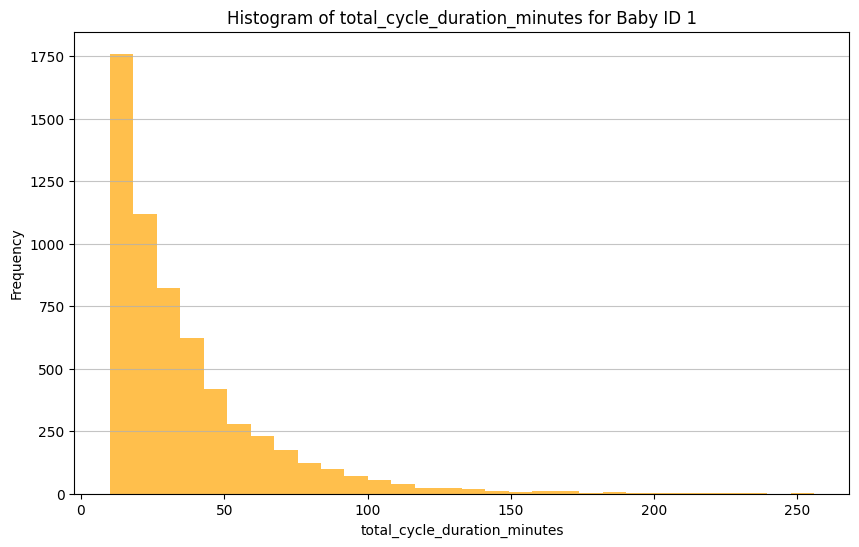

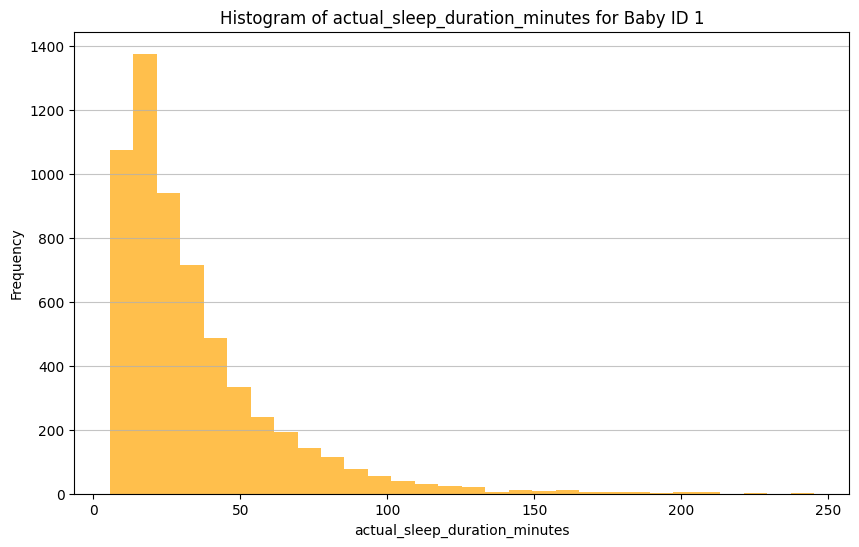

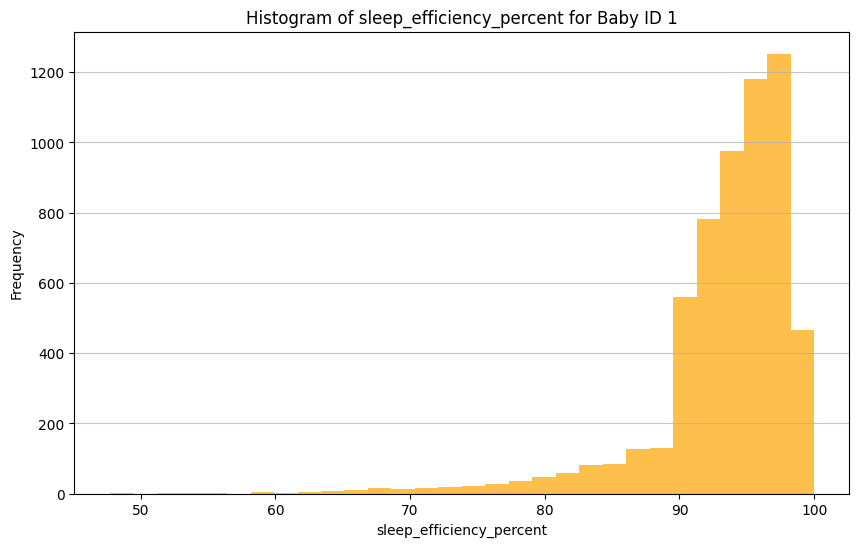

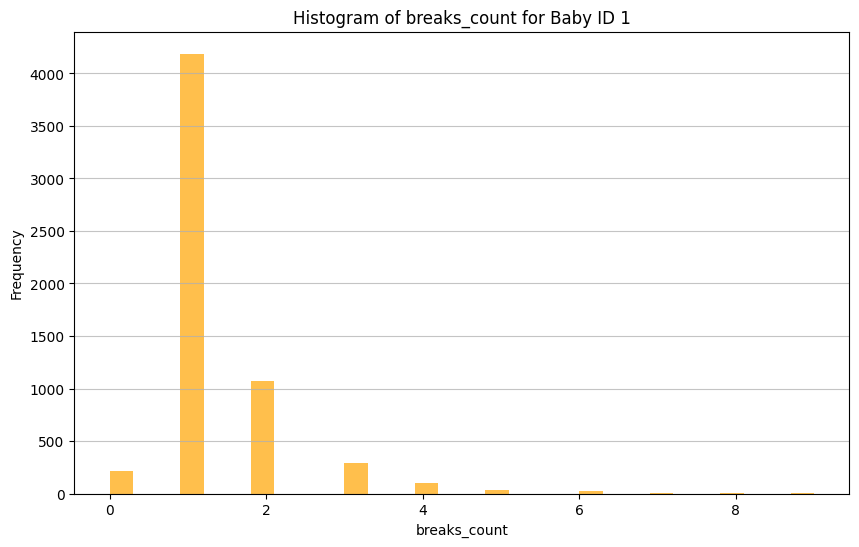

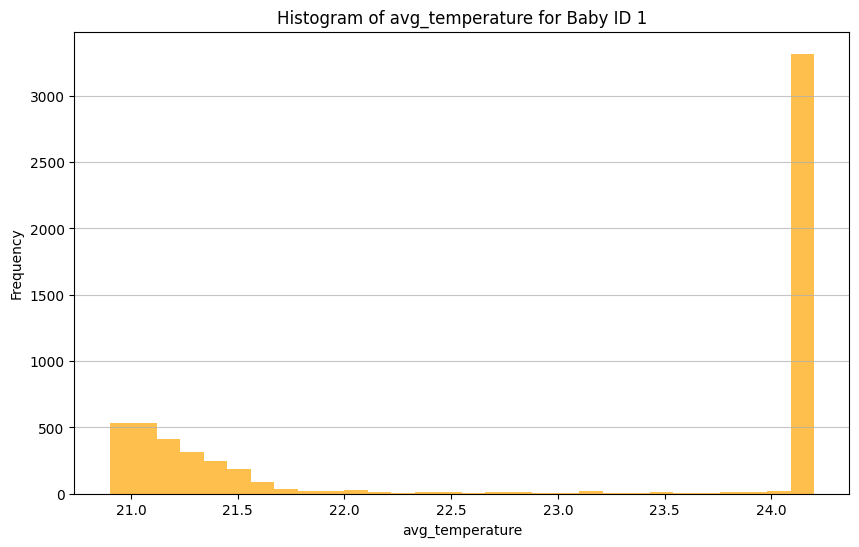

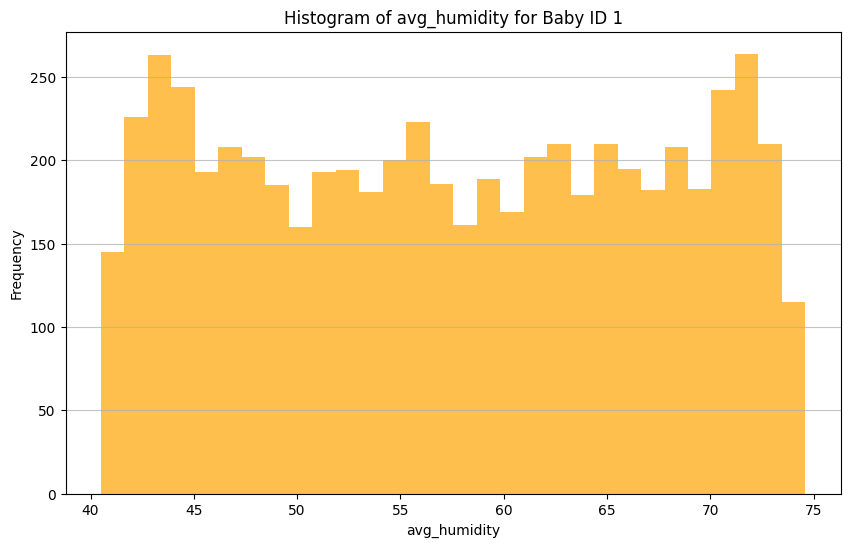

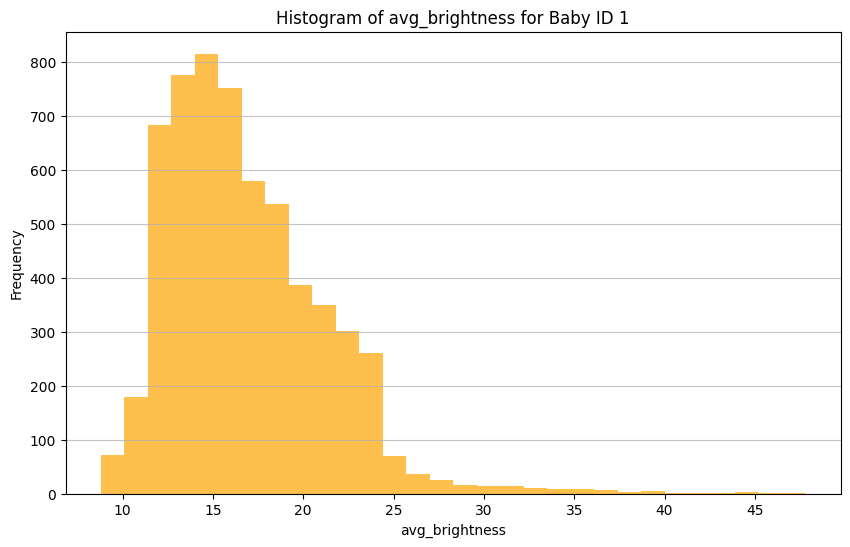

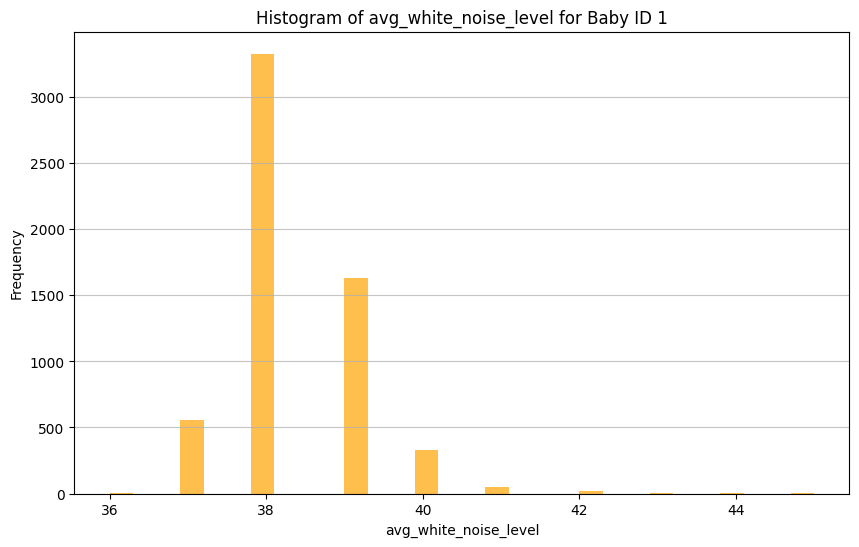

In [11]:
# baby_id=1인 값들을 대상으로 모든 칼럼에 대해 시각화
baby_id = 1
baby_df = df[df['baby_id'] == baby_id]
# 시각화할 칼럼 리스트
columns_to_plot = [
    'total_cycle_duration_minutes',
    'actual_sleep_duration_minutes',
    'sleep_efficiency_percent',
    'breaks_count',
    'avg_temperature',
    'avg_humidity',
    'avg_brightness',
    'avg_white_noise_level'
]
# 각 칼럼에 대해 히스토그램 시각화
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.hist(baby_df[column].dropna(), bins=30, alpha=0.7, color='orange')
    plt.title(f'Histogram of {column} for Baby ID {baby_id}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()